In [1]:
from typing import Dict, List, Tuple, Union

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import empyrical as ep
from data_service import (get_interpld_shibor, get_shibor_data, prepare_data,
                          query_china_shibor_all)
from jqdata import *

from scr.calc_func import (CVIX, prepare_data2calc, get_n_next_ret,
                           get_quantreg_res,create_quantile_bound)

from scr.plotting import (plot_group_ret, plot_hist2d, plot_indicator,
                          plot_quantreg_res)

from scr.utils import load_csv
# 设置字体 用来正常显示中文标签
mpl.rcParams['font.sans-serif'] = ['SimHei']
#mpl.rcParams['font.family'] = 'serif'
# 用来正常显示负号
mpl.rcParams['axes.unicode_minus'] = False


d:\anaconda3\lib\site-packages\empyrical\utils.py:32: UserWarning: Unable to import pandas_datareader. Suppressing import error and continuing. All data reading functionality will raise errors; but has been deprecated and will be removed in a later version.
  warnings.warn(msg)


本篇算法来源：
>《20180707_东北证券_金融工程_市场波动风险度量：vix与skew指数构建与应用》

In [ ]:
# 数据获取
start, end = '2015-02-09', '2022-05-27'
opt_data = prepare_data('510050.XSHG', start, end)
shibor_df = get_shibor_data(start, end)

# 插值
interpld_shibor = get_interpld_shibor(shibor_df)

In [4]:
# 数据储存
opt_data.to_csv(r'../Data/opt_data.csv')
interpld_shibor.to_csv(r'../Data/interpld_shibor.csv')

In [2]:
# 数据读取
opt_data: pd.DataFrame = pd.read_csv(r'Data/opt_data.csv',
                                     index_col=[0],
                                     parse_dates=['date'])

interpld_shibor: pd.DataFrame = pd.read_csv(r'Data/interpld_shibor.csv',
                                            index_col=[0],
                                            parse_dates=True)

interpld_shibor.columns = list(map(int, interpld_shibor.columns))

# 加载数据
price:pd.DataFrame = load_csv(r'.\Data\price.csv')
sz50:pd.DataFrame = price.query('code == "000016.XSHG"').copy()
sz50:pd.DataFrame = sz50.set_index('datetime').drop(columns=['code'])

hs300:pd.DataFrame = price.query('code == "000300.XSHG"').copy()
hs300:pd.DataFrame = hs300.set_index('datetime').drop(columns=['code'])

In [3]:
# 前期数据整理
data_all = prepare_data2calc(opt_data, interpld_shibor)

In [4]:
# 加载模块
vix_func = CVIX(data_all)

In [5]:
# 计算vix
vix: pd.Series = vix_func.vix()

# 计算skew
skew: pd.Series = vix_func.skew()


d:\WrokSpace\Quantitative-analysis\C-择时类\C-VIX中国版VIX编制手册\scr\calc_func.py:171: UserWarning: F:2.7309,strike_marix中最小执行价为:2.7500,故开跌部分无数据,无中间价K0.
  warnings.warn('F:%.4f,strike_marix中最小执行价为:%.4f,故开跌部分无数据,无中间价K0.' %
d:\WrokSpace\Quantitative-analysis\C-择时类\C-VIX中国版VIX编制手册\scr\calc_func.py:171: UserWarning: F:2.7550,strike_marix中最小执行价为:2.8000,故开跌部分无数据,无中间价K0.
  warnings.warn('F:%.4f,strike_marix中最小执行价为:%.4f,故开跌部分无数据,无中间价K0.' %
d:\WrokSpace\Quantitative-analysis\C-择时类\C-VIX中国版VIX编制手册\scr\calc_func.py:171: UserWarning: F:2.4662,strike_marix中最小执行价为:2.5000,故开跌部分无数据,无中间价K0.
  warnings.warn('F:%.4f,strike_marix中最小执行价为:%.4f,故开跌部分无数据,无中间价K0.' %
d:\WrokSpace\Quantitative-analysis\C-择时类\C-VIX中国版VIX编制手册\scr\calc_func.py:171: UserWarning: F:2.4619,strike_marix中最小执行价为:2.5000,故开跌部分无数据,无中间价K0.
  warnings.warn('F:%.4f,strike_marix中最小执行价为:%.4f,故开跌部分无数据,无中间价K0.' %
d:\WrokSpace\Quantitative-analysis\C-择时类\C-VIX中国版VIX编制手册\scr\calc_func.py:171: UserWarning: F:2.3890,strike_marix中最小执行价为:2.4000,故开跌部分无数据,无中间价K0.

## VIX、STEW与上证50的关系

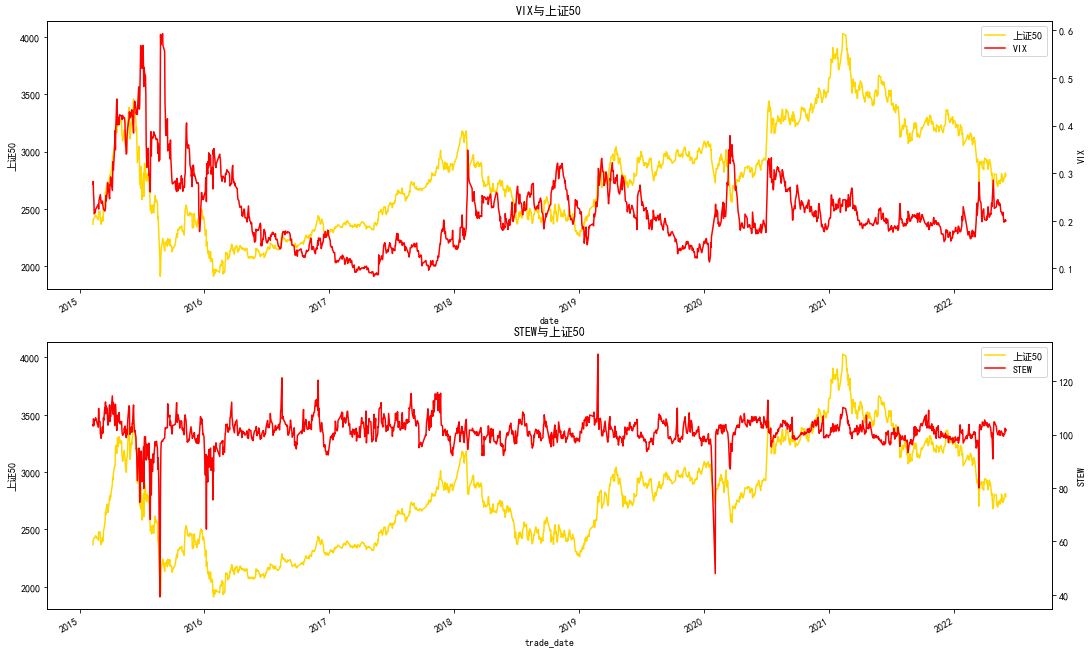

In [6]:
fig, axes = plt.subplots(2, figsize=(18, 12), sharex=False)

plot_indicator(sz50['close'],
               vix, ['上证50', 'VIX'], ['上证50', 'VIX'],
               'VIX与上证50',
               ax=axes[0])

plot_indicator(sz50['close'],
               skew, ['上证50', 'STEW'], ['上证50', 'STEW'],
               'STEW与上证50',
               ax=axes[1]);


## VIX、STEW与沪深300的关系

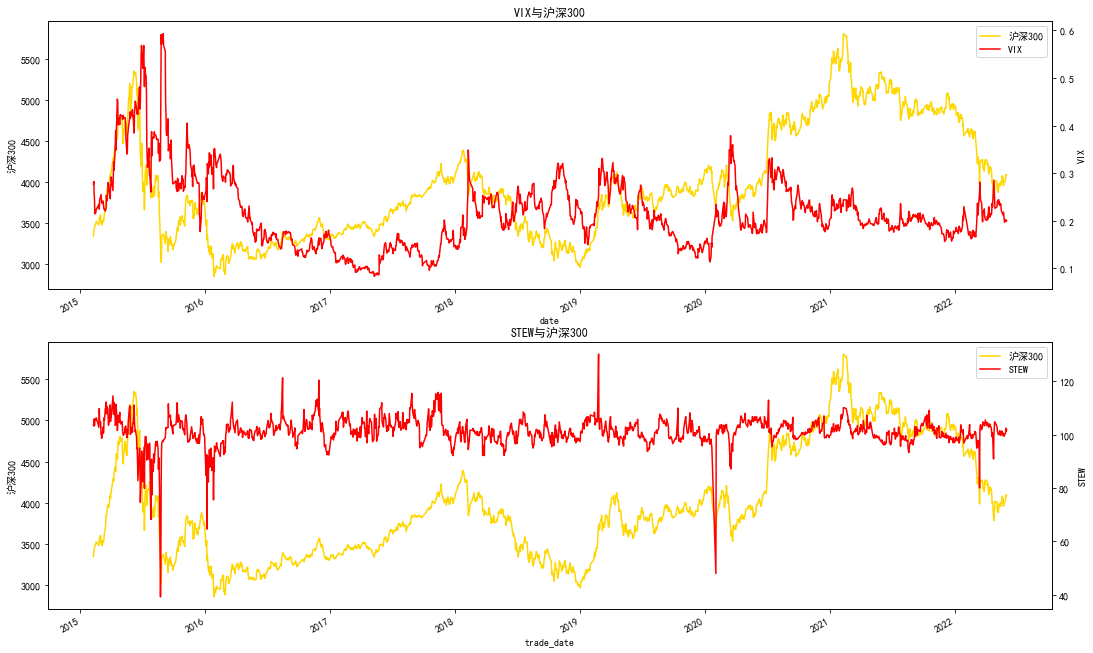

In [7]:
fig, axes = plt.subplots(2, figsize=(18, 12), sharex=False)

plot_indicator(hs300['close'],
               vix, ['沪深300', 'VIX'], ['沪深300', 'VIX'],
               'VIX与沪深300',
               ax=axes[0])

plot_indicator(hs300['close'],
               skew, ['沪深300', 'STEW'], ['沪深300', 'STEW'],
               'STEW与沪深300',
               ax=axes[1]);


## 信号与指数收益的关系

**上证50**

可以看到VIX信号在低分位对应的未来N期收益率均值都有较好的表现;高分位有较明显的拥挤效应出现,对应的是较明显的负向收益。

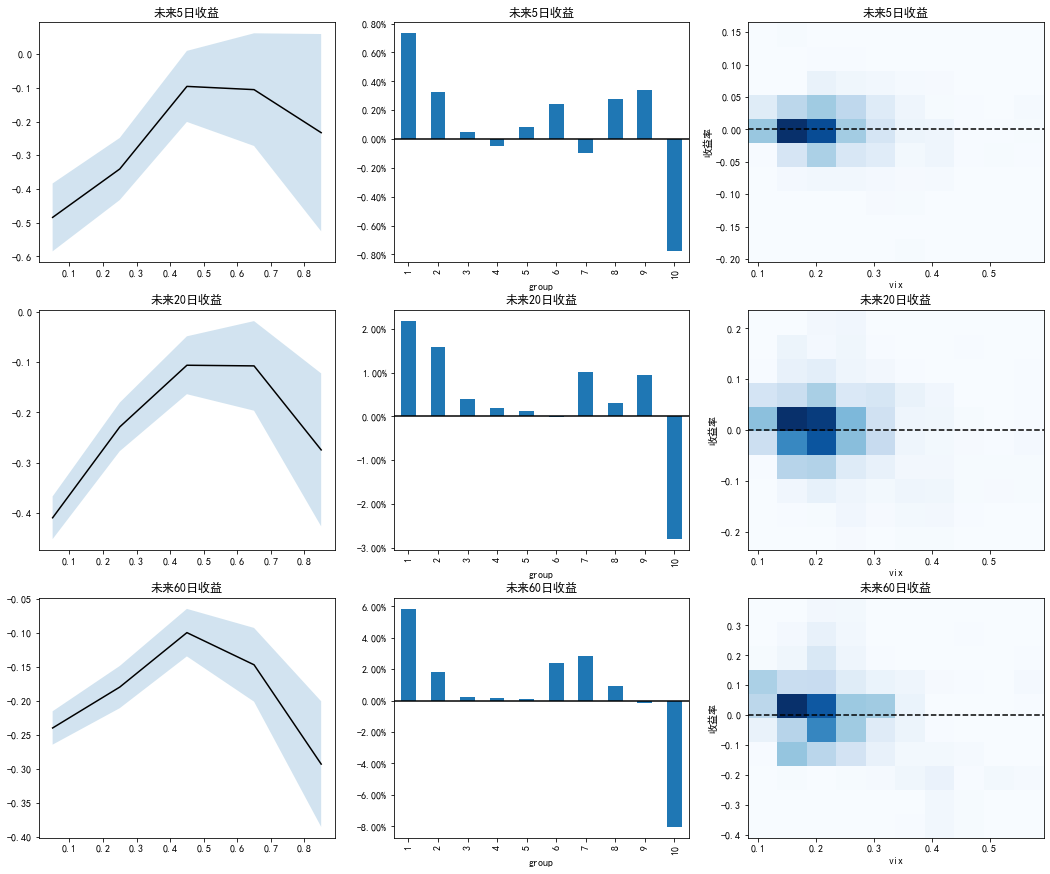

In [8]:
# 上证50与vix的关系

## 对齐未来收益与vix
algin_next_chg, algin_vix = get_n_next_ret(sz50['close'], vix)

## 获取模型结果
models_dic: Dict = {
    name: get_quantreg_res(algin_vix,ser)
    for name, ser in algin_next_chg.items()
}

fig, axes = plt.subplots(3, 3, figsize=(18, 15))

## 画图
for (k, v), ax in zip(models_dic.items(), axes):

    plot_quantreg_res(v, title=k, ax=ax[0])
    plot_group_ret(algin_vix, algin_next_chg[k], title=k, ax=ax[1])
    plot_hist2d(algin_vix, algin_next_chg[k], title=k, ax=ax[2])

**沪深300**

可以看到VIX信号在低分位对应的未来N期收益率均值都有较好的表现;高分位有较明显的拥挤效应出现,对应的是较明显的负向收益。

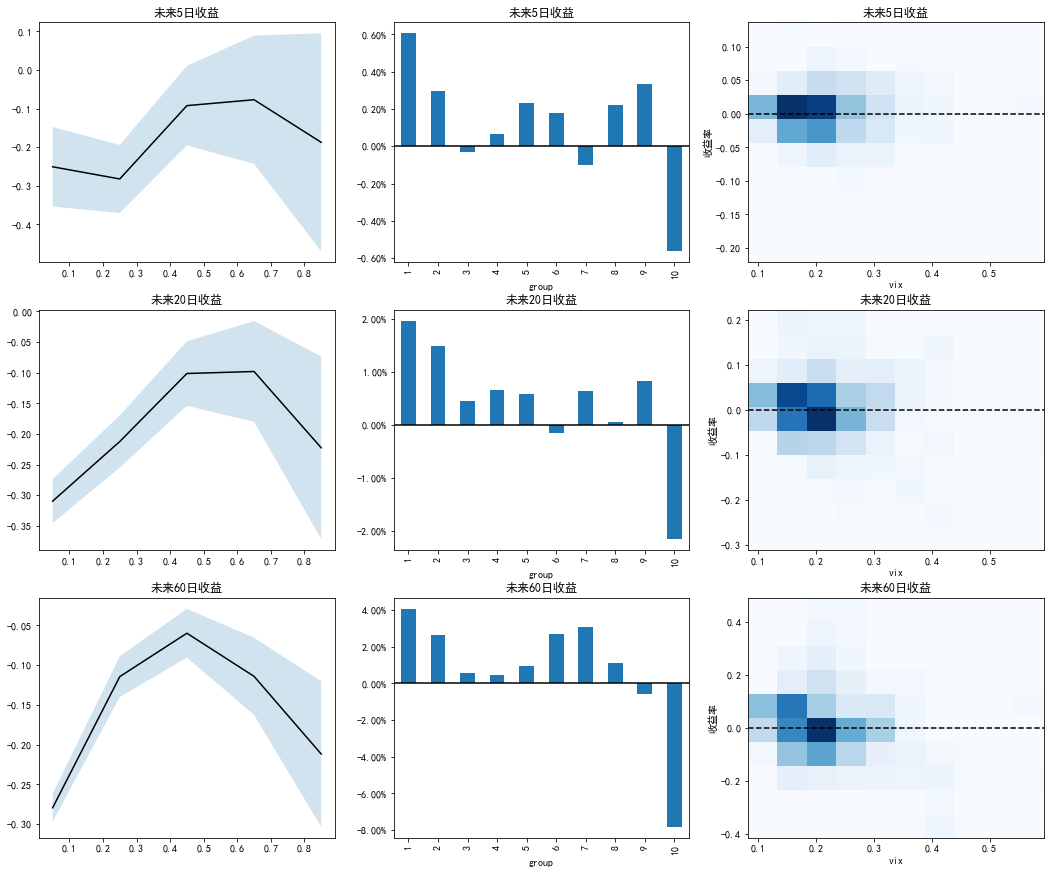

In [9]:
# 沪深300与vix的关系

## 对齐未来收益与vix
algin_next_chg, algin_vix = get_n_next_ret(hs300['close'], vix)

## 获取模型结果
models_dic: Dict = {
    name: get_quantreg_res(algin_vix,ser)
    for name, ser in algin_next_chg.items()
}

fig, axes = plt.subplots(3, 3, figsize=(18, 15))

## 画图
for (k, v), ax in zip(models_dic.items(), axes):

    plot_quantreg_res(v, title=k, ax=ax[0])
    plot_group_ret(algin_vix, algin_next_chg[k], title=k, ax=ax[1])
    plot_hist2d(algin_vix, algin_next_chg[k], title=k, ax=ax[2])

### 根据收益与VIX关系构造上下轨

#### 上证50

由上可知在VIX低于20%分为数有较高的上涨概率,故根据上面的结论构建信号

In [6]:
from scr.bt_func import (get_backtesting, vix_over_quantile_bound_strategy,
                         analysis_trade,analysis_rets)
from scr.plotting import plot_algorithm_nav, plot_qunatile_signal


##### 信号
根据VIX构成上下轨

- 上轨:滚动240日的85%百分位数生成上轨
- 下轨:滚动240日的20%百分位数生成下轨

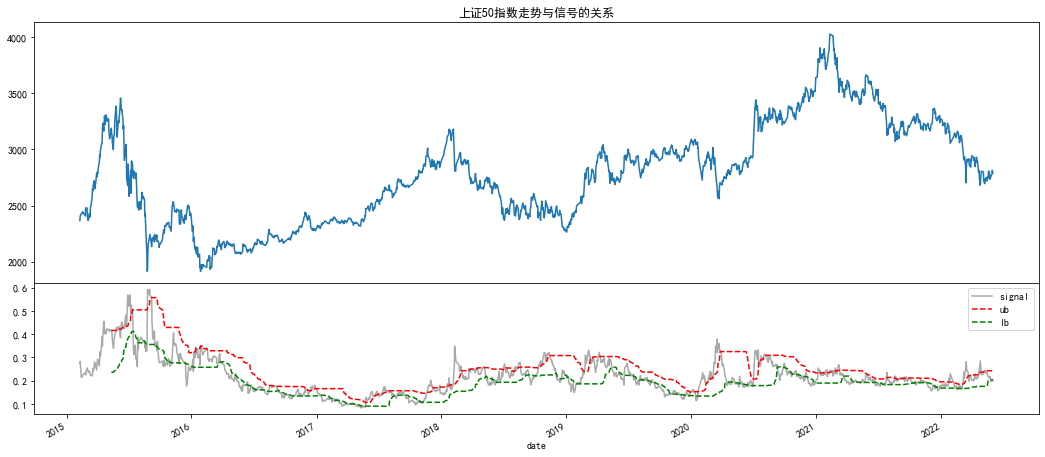

In [7]:
plot_qunatile_signal(sz50['close'], vix, 60, (85, 20), '上证50指数走势与信号的关系');

##### 回测

In [41]:
# 信号生成
quantile_bound:pd.DataFrame = create_quantile_bound(vix,60,(85,20))

# 合并数据
data_all:pd.DataFrame = pd.concat((sz50,quantile_bound),axis=1).dropna()

# 回测
res = get_backtesting(data_all,'000016.SH',vix_over_quantile_bound_strategy)

signal <backtrader.linebuffer.LineBuffer object at 0x0000025F59F45A00>
2015-07-16,BUY EXECUTED,ref:259,Price:2755.1055,Size:32.00,Cost:88163.3755,Comm 0.0000,Stock:000016.SH
2015-09-08,SELL EXECUTED,ref:260,Price:2115.6884,Size:-32.00,Cost:88163.3755,Comm 0.0000,Stock:000016.SH
2015-09-17,BUY EXECUTED,ref:261,Price:2223.6223,Size:31.00,Cost:68932.2925,Comm 0.0000,Stock:000016.SH
2016-01-18,SELL EXECUTED,ref:262,Price:2040.2060,Size:-31.00,Cost:68932.2925,Comm 0.0000,Stock:000016.SH
2016-03-29,BUY EXECUTED,ref:263,Price:2128.0128,Size:31.00,Cost:65968.3962,Comm 0.0000,Stock:000016.SH
2016-09-02,SELL EXECUTED,ref:264,Price:2216.0684,Size:-31.00,Cost:65968.3962,Comm 0.0000,Stock:000016.SH
2016-09-14,BUY EXECUTED,ref:265,Price:2184.3284,Size:31.00,Cost:67714.1807,Comm 0.0000,Stock:000016.SH
2016-12-02,SELL EXECUTED,ref:266,Price:2426.9273,Size:-31.00,Cost:67714.1807,Comm 0.0000,Stock:000016.SH
2017-01-12,BUY EXECUTED,ref:267,Price:2299.7199,Size:32.00,Cost:73591.0384,Comm 0.0000,Stock:0000

,年化收益率,累计收益,波动率,夏普,最大回撤,索提诺比率,Calmar
策略,1.40%,9.93%,15.00%,16.79%,-29.23%,22.85%,4.78%
基准,-1.85%,-11.95%,22.88%,3.34%,-44.70%,4.54%,-4.14%


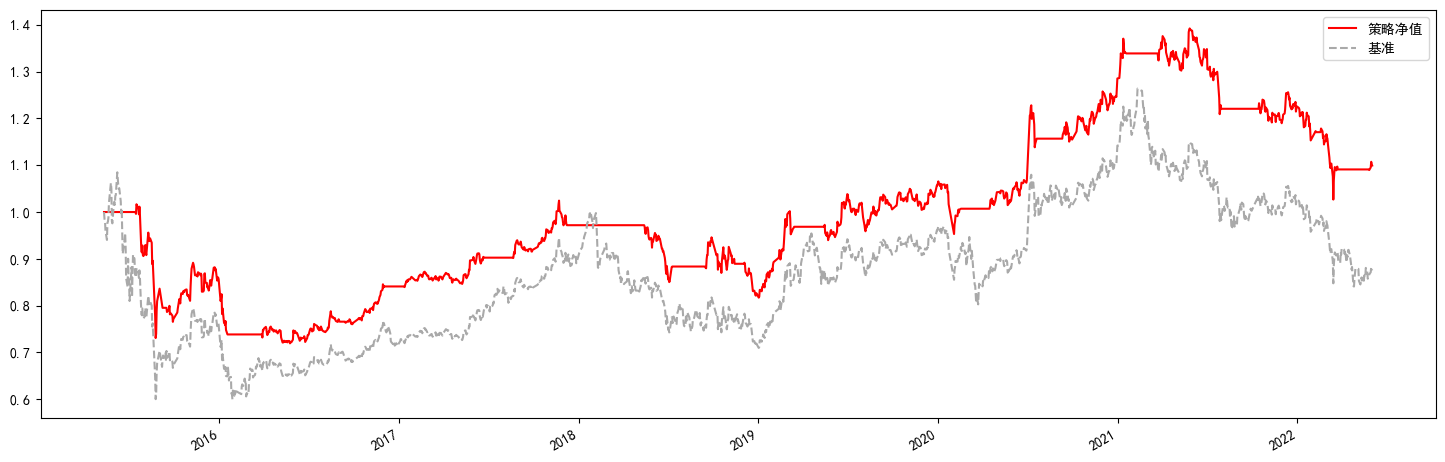

In [42]:
analysis_rets(sz50['close'],res.result)

,总交易次数,持仓最长时间(自然天),持仓最短时间(自然天),平均持仓天数(自然天),胜率(%),盈亏比
交易指标,16,242,32,104.75,56.25%,1.1


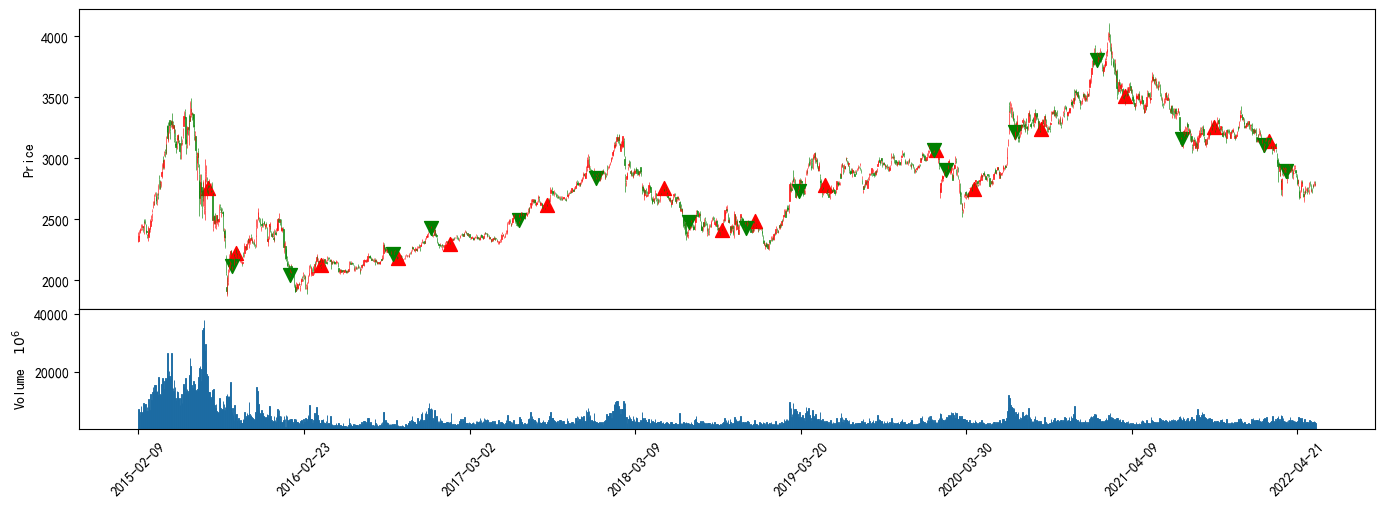

In [43]:
analysis_trade(sz50,res.result)

#### 沪深300

GridSpec(3, 1)

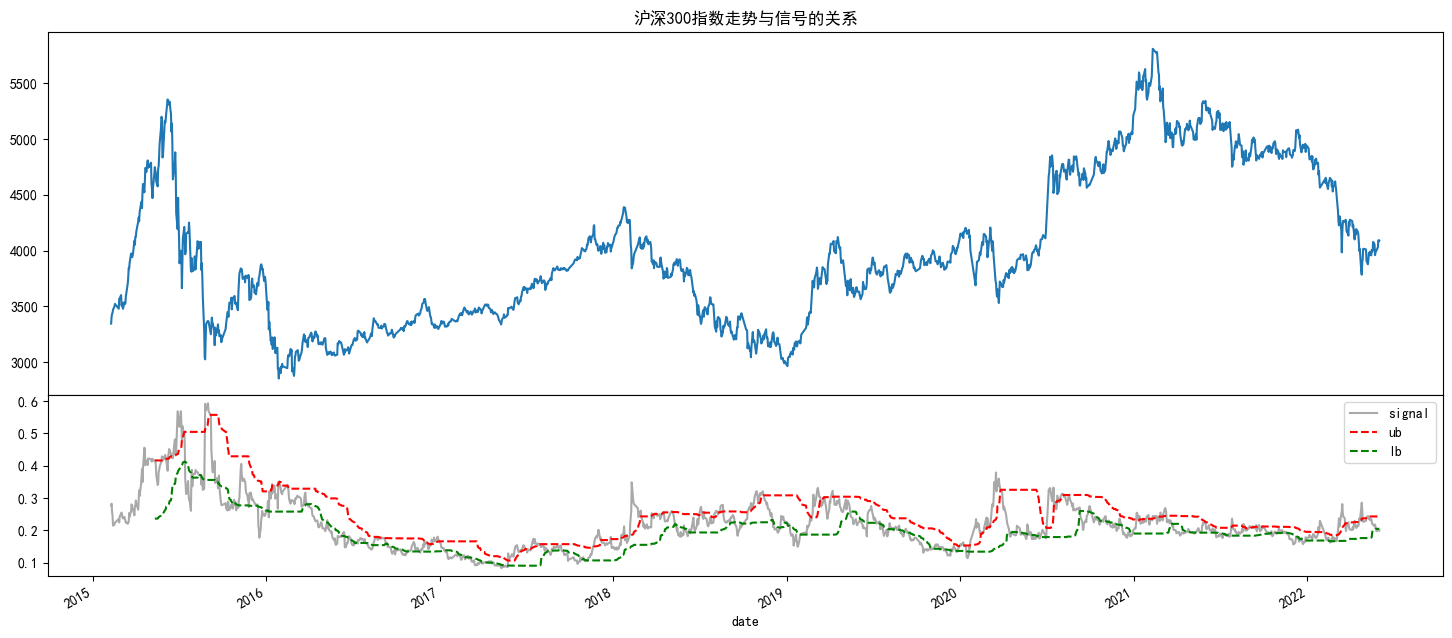

In [44]:
plot_qunatile_signal(hs300['close'], vix, 60, (85, 20), '沪深300指数走势与信号的关系')


In [45]:
# 合并数据
data_all:pd.DataFrame = pd.concat((hs300,quantile_bound),axis=1).dropna()

In [46]:
# 回测
res1 = get_backtesting(data_all,'000300.SH',vix_over_quantile_bound_strategy)

signal <backtrader.linebuffer.LineBuffer object at 0x0000025F59626640>
2015-07-16,BUY EXECUTED,ref:292,Price:3950.0350,Size:22.00,Cost:86900.7692,Comm 0.0000,Stock:000300.SH
2015-09-08,SELL EXECUTED,ref:293,Price:3221.4678,Size:-22.00,Cost:86900.7692,Comm 0.0000,Stock:000300.SH
2015-09-17,BUY EXECUTED,ref:294,Price:3287.9888,Size:22.00,Cost:72335.7529,Comm 0.0000,Stock:000300.SH
2016-01-18,SELL EXECUTED,ref:295,Price:3067.9232,Size:-22.00,Cost:72335.7529,Comm 0.0000,Stock:000300.SH
2016-03-29,BUY EXECUTED,ref:296,Price:3171.6271,Size:22.00,Cost:69775.7969,Comm 0.0000,Stock:000300.SH
2016-09-02,SELL EXECUTED,ref:297,Price:3298.3901,Size:-22.00,Cost:69775.7969,Comm 0.0000,Stock:000300.SH
2016-09-14,BUY EXECUTED,ref:298,Price:3246.0646,Size:22.00,Cost:71413.4206,Comm 0.0000,Stock:000300.SH
2016-12-02,SELL EXECUTED,ref:299,Price:3559.4140,Size:-22.00,Cost:71413.4206,Comm 0.0000,Stock:000300.SH
2017-01-12,BUY EXECUTED,ref:300,Price:3333.0233,Size:23.00,Cost:76659.5352,Comm 0.0000,Stock:0003

,年化收益率,累计收益,波动率,夏普,最大回撤,索提诺比率,Calmar
策略,3.80%,28.94%,14.96%,32.45%,-28.10%,43.60%,13.51%
基准,-1.99%,-12.81%,23.23%,3.05%,-46.70%,4.06%,-4.26%


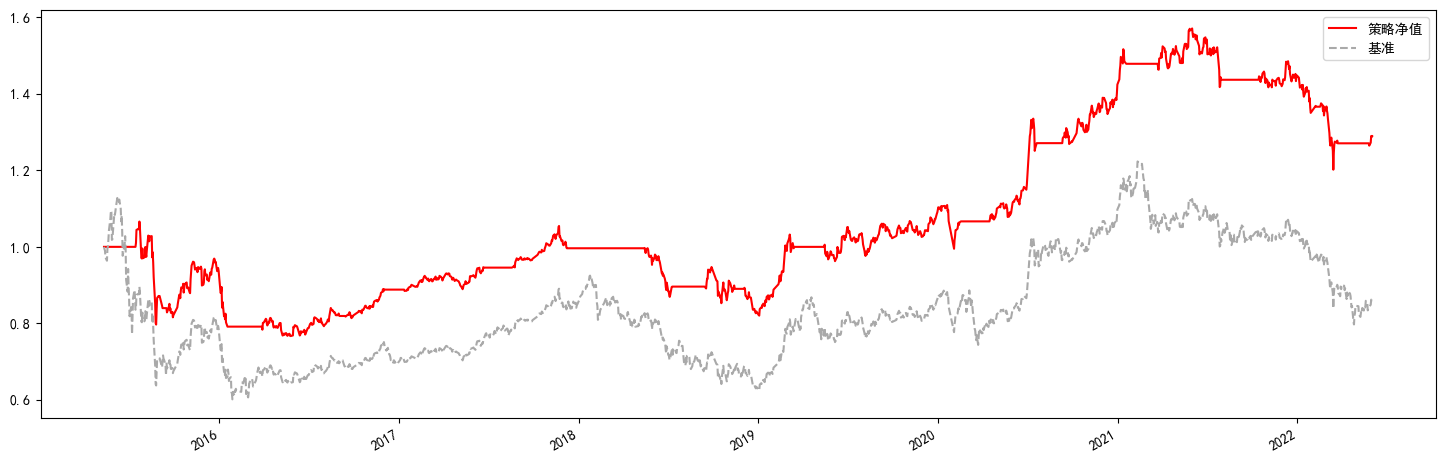

In [47]:
analysis_rets(hs300['close'],res1.result)

,总交易次数,持仓最长时间(自然天),持仓最短时间(自然天),平均持仓天数(自然天),胜率(%),盈亏比
交易指标,16,242,32,104.75,50.00%,1.5


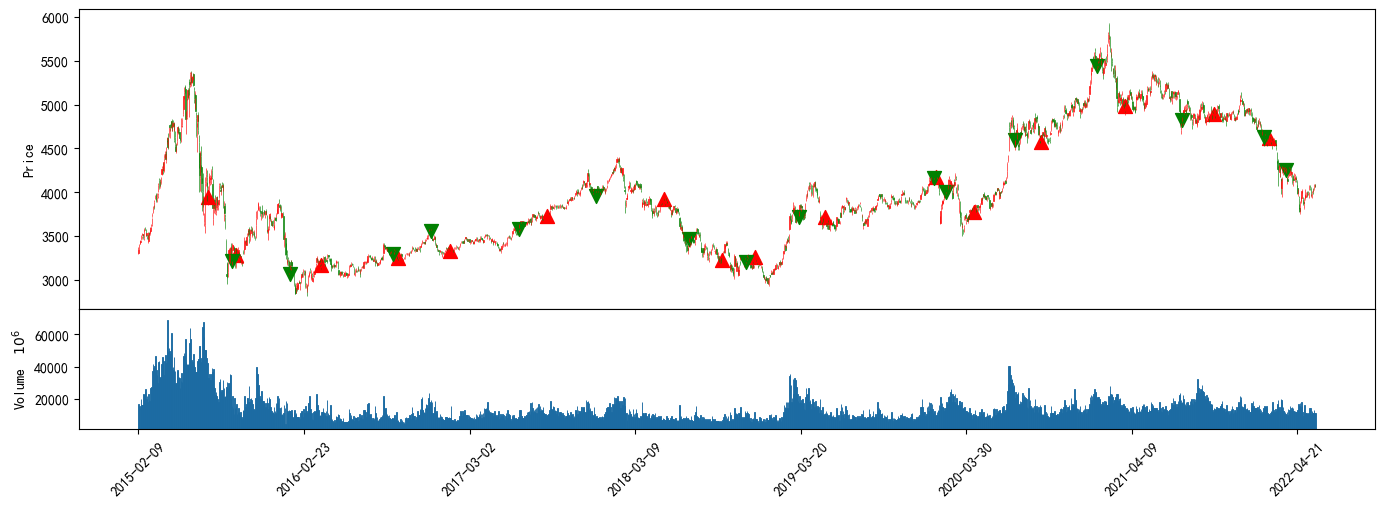

In [48]:
analysis_trade(hs300,res1.result)